In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold, ParameterGrid

from gpalib import preprocessing
from gpalib import analysis
from gpalib import model

In [2]:
"""Display settings"""
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 300

In [3]:
RANDOM_SEED = 42

In [4]:
data = pd.read_csv('../data/russia-16-19-v2.5.csv')
print(data.shape)
data.head()

(308273, 187)


,sup_running_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty_share,sup_no_pnl_share,sup_sim_price_share,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_mun_cntr_share,org_cntr_num,org_cntr_avg_price,org_sim_price_share,org_type,org_ter,org_good_cntr_share,cntr_num_together,okpd_cntr_num,okpd_good_share_min,sign_month,cntr_okpd_num,plan_cntr_len,day_price,purch_type,cntr_lvl,okpd2_0,okpd2_10,okpd2_11,okpd2_12,okpd2_13,okpd2_14,okpd2_15,okpd2_16,okpd2_17,okpd2_18,okpd2_19,okpd2_20,okpd2_21,okpd2_22,okpd2_23,okpd2_24,okpd2_25,okpd2_26,okpd2_27,okpd2_28,okpd2_29,okpd2_30,okpd2_31,okpd2_32,okpd2_33,okpd2_35,okpd2_36,okpd2_37,okpd2_38,okpd2_39,okpd2_41,okpd2_42,okpd2_43,okpd2_45,okpd2_46,okpd2_47,okpd2_49,okpd2_50,okpd2_51,okpd2_52,okpd2_53,okpd2_55,okpd2_56,okpd2_58,okpd2_59,okpd2_60,okpd2_61,okpd2_62,okpd2_63,okpd2_64,okpd2_65,okpd2_66,okpd2_68,okpd2_69,okpd2_70,okpd2_71,okpd2_72,okpd2_73,okpd2_74,okpd2_75,okpd2_77,okpd2_78,okpd2_79,okpd2_80,okpd2_81,okpd2_82,okpd2_84,okpd2_85,okpd2_86,okpd2_87,okpd2_88,okpd2_89,okpd2_90,okpd2_91,okpd2_93,okpd2_94,okpd2_95,okpd2_96,okpd2_97,okpd2_98,okpd2_99,socs_0,socs_10,socs_11,socs_12,socs_13,socs_14,socs_15,socs_16,socs_17,socs_18,socs_19,socs_20,socs_21,socs_22,socs_23,socs_24,socs_25,socs_26,socs_27,socs_28,socs_29,socs_30,socs_31,socs_32,socs_33,socs_35,socs_36,socs_37,socs_38,socs_39,socs_41,socs_42,socs_43,socs_45,socs_46,socs_47,socs_49,socs_50,socs_51,socs_52,socs_53,socs_55,socs_56,socs_58,socs_59,socs_60,socs_61,socs_62,socs_63,socs_64,socs_65,socs_66,socs_68,socs_69,socs_70,socs_71,socs_72,socs_73,socs_74,socs_75,socs_77,socs_78,socs_79,socs_80,socs_81,socs_82,socs_84,socs_85,socs_86,socs_87,socs_88,socs_89,socs_90,socs_91,socs_93,socs_94,socs_95,socs_96,socs_97,socs_98,socs_99,cntr_result
0,2.197,11.950,0.000,1,0.200,1.000,0.100,0.900,0.000,6.821,13.221,0.080,16,67162,0.989,0.000,13.905,0.590,8,0.000,4.812,6.824,3,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.800,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
1,4.511,10.900,0.000,1,0.100,1.000,0.017,0.500,0.483,4.094,12.610,0.150,30,67162,0.933,0.000,12.804,0.617,5,3.045,5.455,5.519,3,3,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.133,0.000,0.000,0.000,0.000,0.967,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.833,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
2,4.564,11.343,0.000,1,0.057,0.681,0.000,0.270,0.730,5.118,12.360,0.114,16,52550,0.874,2.197,13.194,0.515,2,1.099,5.765,5.707,4,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.716,0.071,0.000,0.000,0.021,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.043,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

In [5]:
classifiers = [
    model.Classifier(
        LogisticRegression(solver='liblinear', random_state=RANDOM_SEED), 
        'LogisticRegression', 'LogReg', 'LR'),
    model.Classifier(
        RandomForestClassifier(n_estimators=10, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1), 
        'RandomForestClassifier', 'RandForest', 'RF'),
    model.Classifier(
        XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1), 
        'XGBoostClassifier', 'XGBoost', 'XGB'),
]

In [6]:
%%time
scores = {}
metrics = ('roc_auc', 'accuracy', 'neg_log_loss')

for clf in classifiers:
    score = model.cross_validate(clf, data, metrics, cv=2, prefix='cv_v4')
    scores[clf.short_name] = score

LogReg: fold 1
LogReg: fold 2
RandForest: fold 1
RandForest: fold 2
XGBoost: fold 1
XGBoost: fold 2
CPU times: user 4min 20s, sys: 41.6 s, total: 5min 1s
Wall time: 5min 28s


In [7]:
model.transform_cros_val_scores(scores)

,model,time,tst_acc,tst_acc_std,tst_auc,tst_auc_std,tst_ll,tst_ll_std,tr_acc,tr_acc_std,tr_auc,tr_auc_std,tr_ll,tr_ll_std
0,LogReg,15.671,0.916,0.001,0.916,0.001,-0.311,0.001,0.859,0.000,0.916,0.001,-0.309,0.001
1,RandForest,2.546,0.889,0.014,0.889,0.014,-0.389,0.012,0.822,0.004,0.891,0.012,-0.387,0.010
2,XGBoost,67.322,0.957,0.001,0.957,0.001,-0.225,0.001,0.896,0.001,0.958,0.001,-0.223,0.001


In [8]:
res = model.feature_importance(classifiers, data)
res.head()

,LogReg,RandForest,XGBoost
0,sign_month: -6.82,sup_fed_cntr_share: 0.20,sup_fed_cntr_share: 0.20
1,sup_fed_cntr_share: -4.88,cntr_num_together: 0.16,cntr_num_together: 0.16
2,sup_no_pnl_share: 2.20,sign_month: 0.13,sign_month: 0.13
3,cntr_num_together: -2.15,cntr_okpd_num: 0.09,cntr_okpd_num: 0.09
4,okpd2_91: -1.53,socs_11: 0.06,socs_11: 0.06


In [10]:
model.custom_classification_report(classifiers)

,LogReg,RandForest,XGBoost
precision_0,0.886,0.818,0.931
precision_1,0.751,0.801,0.782
recall_0,0.932,0.973,0.929
recall_1,0.632,0.334,0.788
accuracy,0.858,0.817,0.894


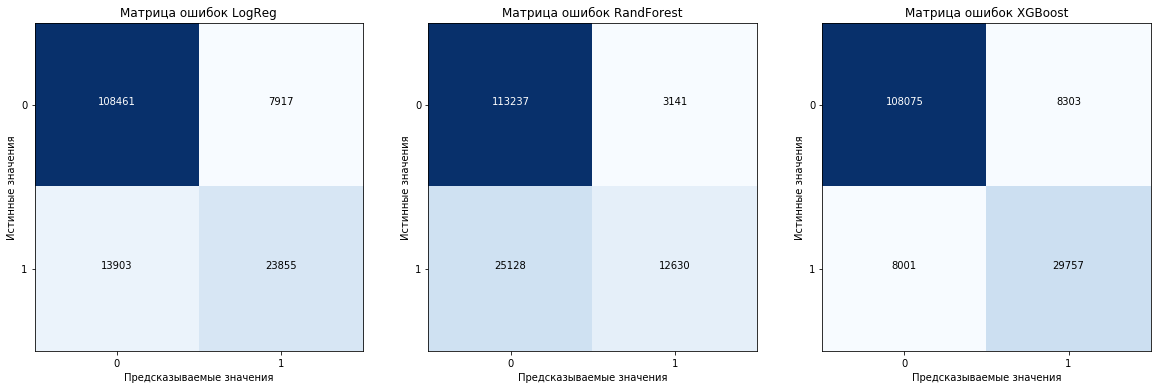

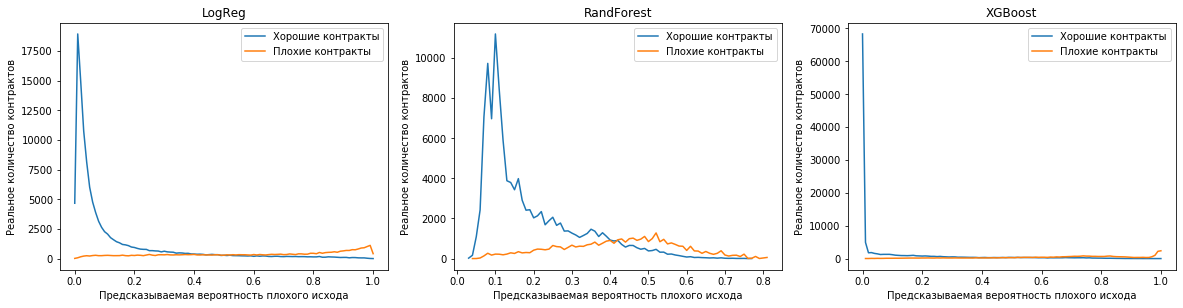

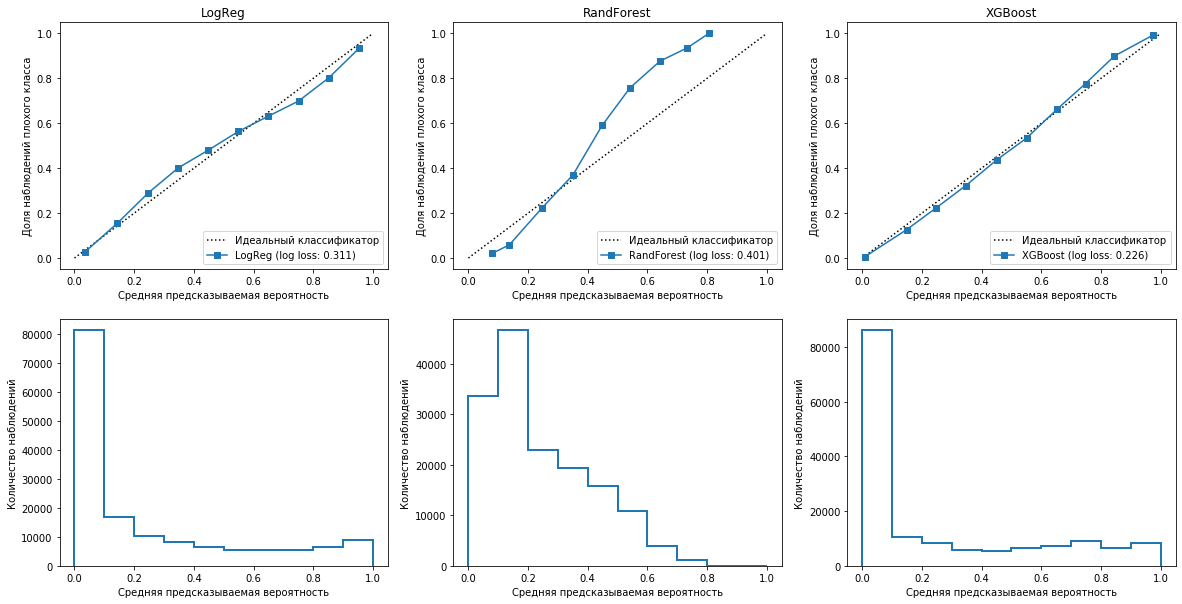

In [12]:
model.visualize_clfs_quality(classifiers)